In [1]:
import shapely
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

In [2]:
# initial value
X_MIN = 0
Y_MIN = 0

X_MAX = 100
Y_MAX = 100

RADIUS = 20

NUM_POINT = 13 # adjust accordingly

In [3]:
# define region
region = shapely.geometry.Polygon([
    (X_MIN, Y_MIN),
    (X_MAX, Y_MIN),
    (X_MAX, Y_MAX),
    (X_MIN, Y_MAX)
])

In [4]:
# define objective function
def objective_function(flat_points):

    points = flat_points.reshape(NUM_POINT, 2)

    circles = dict()
    for i, [x, y] in enumerate(points):
        circles[i] = shapely.Point(x, y).buffer(distance=RADIUS, resolution=128)

    total_intersect_area = 0
    for i in range(len(circles)):
        for j in range(len(circles)):
            total_intersect_area += circles[i].intersection(circles[j]).area

    total_intersect_area = total_intersect_area - \
                           len(circles) * circles[0].intersection(circles[0]).area

    return np.array(total_intersect_area)

In [5]:
# define constraint
def constraint(flat_points):

    points = flat_points.reshape(NUM_POINT, 2)

    circles = dict()
    for i, [x, y] in enumerate(points):
        circles[i] = shapely.Point(x, y).buffer(distance=20, resolution=128)

    union_circle = circles[0]
    for i in range(len(circles)):
        union_circle = union_circle.union(circles[i])

    constraint_area = region.intersection(union_circle).area
    return constraint_area

In [6]:
# define initial value
x0 = np.random.uniform(low=0, high=100, size=(NUM_POINT, 2)).reshape(2 * NUM_POINT)

# define boundary
bounds = [(0., 100.)]

# nonlinear constraint
nlc = NonlinearConstraint(constraint, region.area, np.inf)


In [7]:
# minimize objective function
result = minimize(
    fun=objective_function,
    x0=x0,
    bounds=bounds,
    tol=1e-1,
    constraints=nlc,
    options={
        # "maxiter": 500,
        'disp': True,
    }
)

c:\Users\ains_sengly\anaconda3\envs\venv_01\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 5248.7462816241805
            Iterations: 78
            Function evaluations: 2191
            Gradient evaluations: 78


In [8]:
# test constraint
constraint(result.x)

9999.976980064455

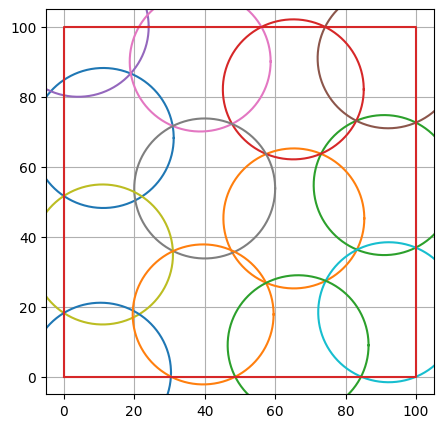

In [9]:
# plot the optimal value
points_opt = result.x.reshape(NUM_POINT, 2)

circles = dict()
for i, [x, y] in enumerate(points_opt):
    circles[i] = shapely.Point(x, y).buffer(distance=RADIUS, resolution=128)

plt.figure(figsize=(5, 5))

for i, _ in enumerate(circles):
    x, y = circles[i].exterior.xy
    plt.plot(x, y)

x, y = region.exterior.xy
plt.plot(x, y)

plt.xlim(-5, 105)
plt.ylim(-5, 105)
plt.grid()
plt.show()